# Бэктестинг стратегии парного трейдинга

## Аннотация

Данная работа представляет комплексный анализ эффективности стратегии парного трейдинга на примере обыкновенных и привилегированных акций ПАО Сбербанк (тикеры `SRM5` и `SPM5`). Исследование включает проверку коинтеграции временных рядов, анализ стационарности спреда, разработку торговых сигналов на основе Z-score и оценку эффективности стратегии с учетом транзакционных издержек.

## Методология

1. **Анализ коинтеграции** - применение теста Энгла-Грейнджера для проверки долгосрочной равновесной связи между инструментами
2. **Проверка стационарности** - тест Дики-Фуллера для спреда между временными рядами  
3. **Генерация торговых сигналов** - использование Z-score с заданными порогами входа и выхода
4. **Бэктестинг** - тестирование стратегии на исторических данных с учетом комиссий
5. **Анализ рисков** - оценка максимальной просадки и применение метода Монте-Карло


In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
import warnings

from core.data import DataManager 
from core.analysis import DataAnalyzer
from core.backtest import Backtester

logging.basicConfig(
    level=logging.WARNING,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'lines.linewidth': 1.5,
    'axes.spines.top': False,
    'axes.spines.right': False
})

## 1. Загрузка и подготовка данных

В данном разделе производится загрузка исторических данных по ценам обыкновенных и привилегированных акций ПАО Сбербанк из CSV-файлов. Данные содержат почасовые котировки с указанием цен открытия, закрытия, максимума, минимума и объема торгов.


In [45]:
futures = [
    "SRM5", # обыкновенные акции ПАО Сбербанк
    "SPM5", # привилегированные акции ПАО Сбербанк
]

data_path = '../data/'

try:
    sber_common_path = os.path.join(data_path, 'SRM5.csv')
    sber_preferred_path = os.path.join(data_path, 'SPM5.csv')

    if not os.path.exists(sber_common_path) or not os.path.exists(sber_preferred_path):
        raise FileNotFoundError("Один или оба файла данных не найдены.")

    sber_common = pd.read_csv(sber_common_path)
    sber_preferred = pd.read_csv(sber_preferred_path)

    # Преобразуем столбец 'time' в datetime
    sber_common['time'] = pd.to_datetime(sber_common['time'], unit='s')
    sber_preferred['time'] = pd.to_datetime(sber_preferred['time'], unit='s')
    
    # Устанавливаем 'time' как индекс
    sber_common.set_index('time', inplace=True)
    sber_preferred.set_index('time', inplace=True)

except FileNotFoundError as e:
    print(f"Ошибка: {e}")
    print(f"\nУбедитесь, что CSV файлы находятся в папке {data_path} и названы правильно (SRM5.csv, SPM5.csv).")


In [46]:
print("Данные успешно загружены.")
print(f"Период данных: с {sber_common.index.min()} по {sber_common.index.max()}")
print(f"Количество записей: {len(sber_common)}")

print("\nОбыкновенные акции Сбербанка (SRM5) - первые 5 записей:")
display(sber_common.head())

print("\nПривилегированные акции Сбербанка (SPM5) - первые 5 записей:")
display(sber_preferred.head())

Данные успешно загружены.
Период данных: с 2025-02-19 06:00:00 по 2025-06-18 20:00:00
Количество записей: 1315

Обыкновенные акции Сбербанка (SRM5) - первые 5 записей:


,close,open,high,low,volume
time,,,,,
2025-02-19 06:00:00,33391.0,33180.0,33418.0,33145.0,242
2025-02-19 07:00:00,33155.0,33373.0,33391.0,33150.0,100
2025-02-19 08:00:00,33103.0,33137.0,33152.0,33017.0,214
2025-02-19 09:00:00,33179.0,33109.0,33240.0,33109.0,102
2025-02-19 10:00:00,33300.0,33146.0,33360.0,33144.0,106



Привилегированные акции Сбербанка (SPM5) - первые 5 записей:


,close,open,high,low,volume
time,,,,,
2025-02-19 06:00:00,33230.0,33038.0,33393.0,33038.0,90
2025-02-19 07:00:00,33008.0,33227.0,33227.0,33008.0,6
2025-02-19 08:00:00,32912.0,32911.0,32953.0,32875.0,6
2025-02-19 10:00:00,33174.0,33025.0,33222.0,32969.0,9
2025-02-19 12:00:00,33182.0,33133.0,33182.0,33133.0,3


### 1.1 Визуализация временных рядов цен закрытия

Для предварительного анализа построим график динамики цен закрытия обоих финансовых инструментов. 
Визуальный анализ позволяет оценить общие тренды, волатильность и потенциальную корреляцию между временными рядами.


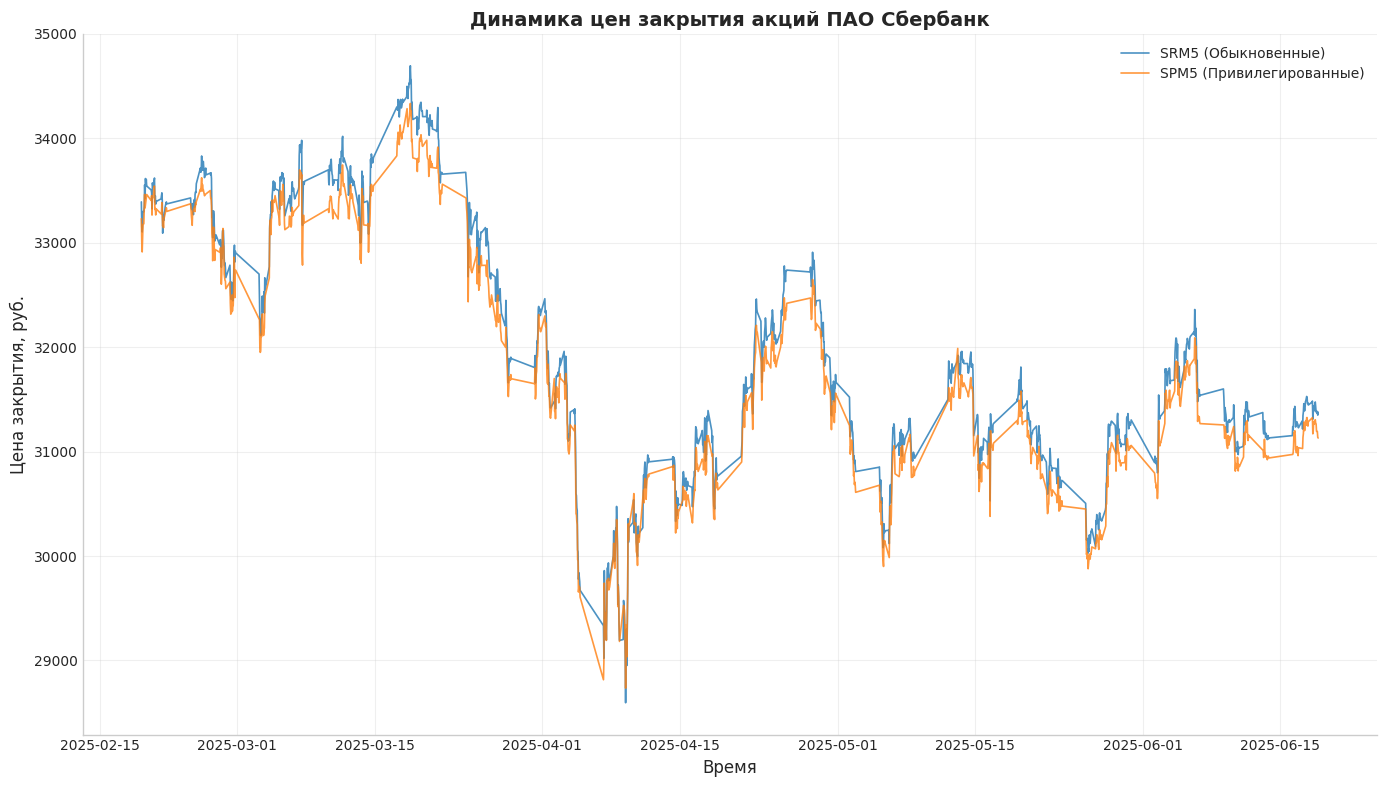

In [47]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(sber_common['close'], label='SRM5 (Обыкновенные)', linewidth=1.2, alpha=0.8)
ax.plot(sber_preferred['close'], label='SPM5 (Привилегированные)', linewidth=1.2, alpha=0.8)
ax.set_title('Динамика цен закрытия акций ПАО Сбербанк', fontweight='bold')
ax.set_xlabel('Время')
ax.set_ylabel('Цена закрытия, руб.')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [48]:

print("Cтатистика цен закрытия:")
print("-" * 50)
print(f"SRM5 (обыкновенные): мин={sber_common['close'].min():.2f}, макс={sber_common['close'].max():.2f}, среднее={sber_common['close'].mean():.2f}")
print(f"SPM5 (привилегированные): мин={sber_preferred['close'].min():.2f}, макс={sber_preferred['close'].max():.2f}, среднее={sber_preferred['close'].mean():.2f}")

correlation = sber_common['close'].corr(sber_preferred['close'])
print(f"\nКоэффициент корреляции Пирсона: {correlation:.4f}")

Cтатистика цен закрытия:
--------------------------------------------------
SRM5 (обыкновенные): мин=28595.00, макс=34695.00, среднее=31946.94
SPM5 (привилегированные): мин=28735.00, макс=34334.00, среднее=31710.71

Коэффициент корреляции Пирсона: 0.9982


## 2. Анализ коинтеграции временных рядов

Коинтеграция представляет собой статистическое свойство временных рядов, при котором линейная комбинация нестационарных рядов является стационарной. Для проверки наличия коинтеграции применяется двухэтапный тест Энгла-Грейнджера, который включает оценку коинтегрирующего уравнения методом наименьших квадратов и последующую проверку стационарности остатков с помощью расширенного теста Дики-Фуллера.


In [49]:
analyzer = DataAnalyzer(alpha=0.05)

merged_data = pd.merge(sber_common, sber_preferred, on='time', how='inner')
series1 = merged_data['close_x']
series2 = merged_data['close_y']

coint_result = analyzer.engle_granger_test(series1, series2)

print("Результаты теста коинтеграции Энгла-Грейнджера")
print("=" * 55)
print(f"P-value: {coint_result['p_value']:.6f}")
print(f"Коэффициент β (хедж-коэффициент): {coint_result['beta']:.4f}")
print(f"Коэффициент α (константа): {coint_result['alpha']:.4f}")
print(f"ADF статистика: {coint_result['adf_statistic']:.4f}")
print(f"Критическое значение (5%): -3.34")

if coint_result['is_cointegrated']:
    print("\nВывод: Временные ряды коинтегрированы на уровне значимости 5%.")
    print("Стратегия парного трейдинга применима для данной пары инструментов.")
else:
    print("\nВывод: Временные ряды не коинтегрированы на уровне значимости 5%.")
    print("Применение стратегии парного трейдинга не рекомендуется.")


Результаты теста коинтеграции Энгла-Грейнджера
P-value: 0.000002
Коэффициент β (хедж-коэффициент): 1.0305
Коэффициент α (константа): -777.7084
ADF статистика: -5.9961
Критическое значение (5%): -3.34

Вывод: Временные ряды коинтегрированы на уровне значимости 5%.
Стратегия парного трейдинга применима для данной пары инструментов.


### 2.1 Анализ спреда и проверка стационарности

Спред определяется как разность между ценами первого и второго инструментов с учетом коинтегрирующих коэффициентов. Для стратегии парного трейдинга критически важна стационарность спреда, которая проверяется с помощью расширенного теста Дики-Фуллера.


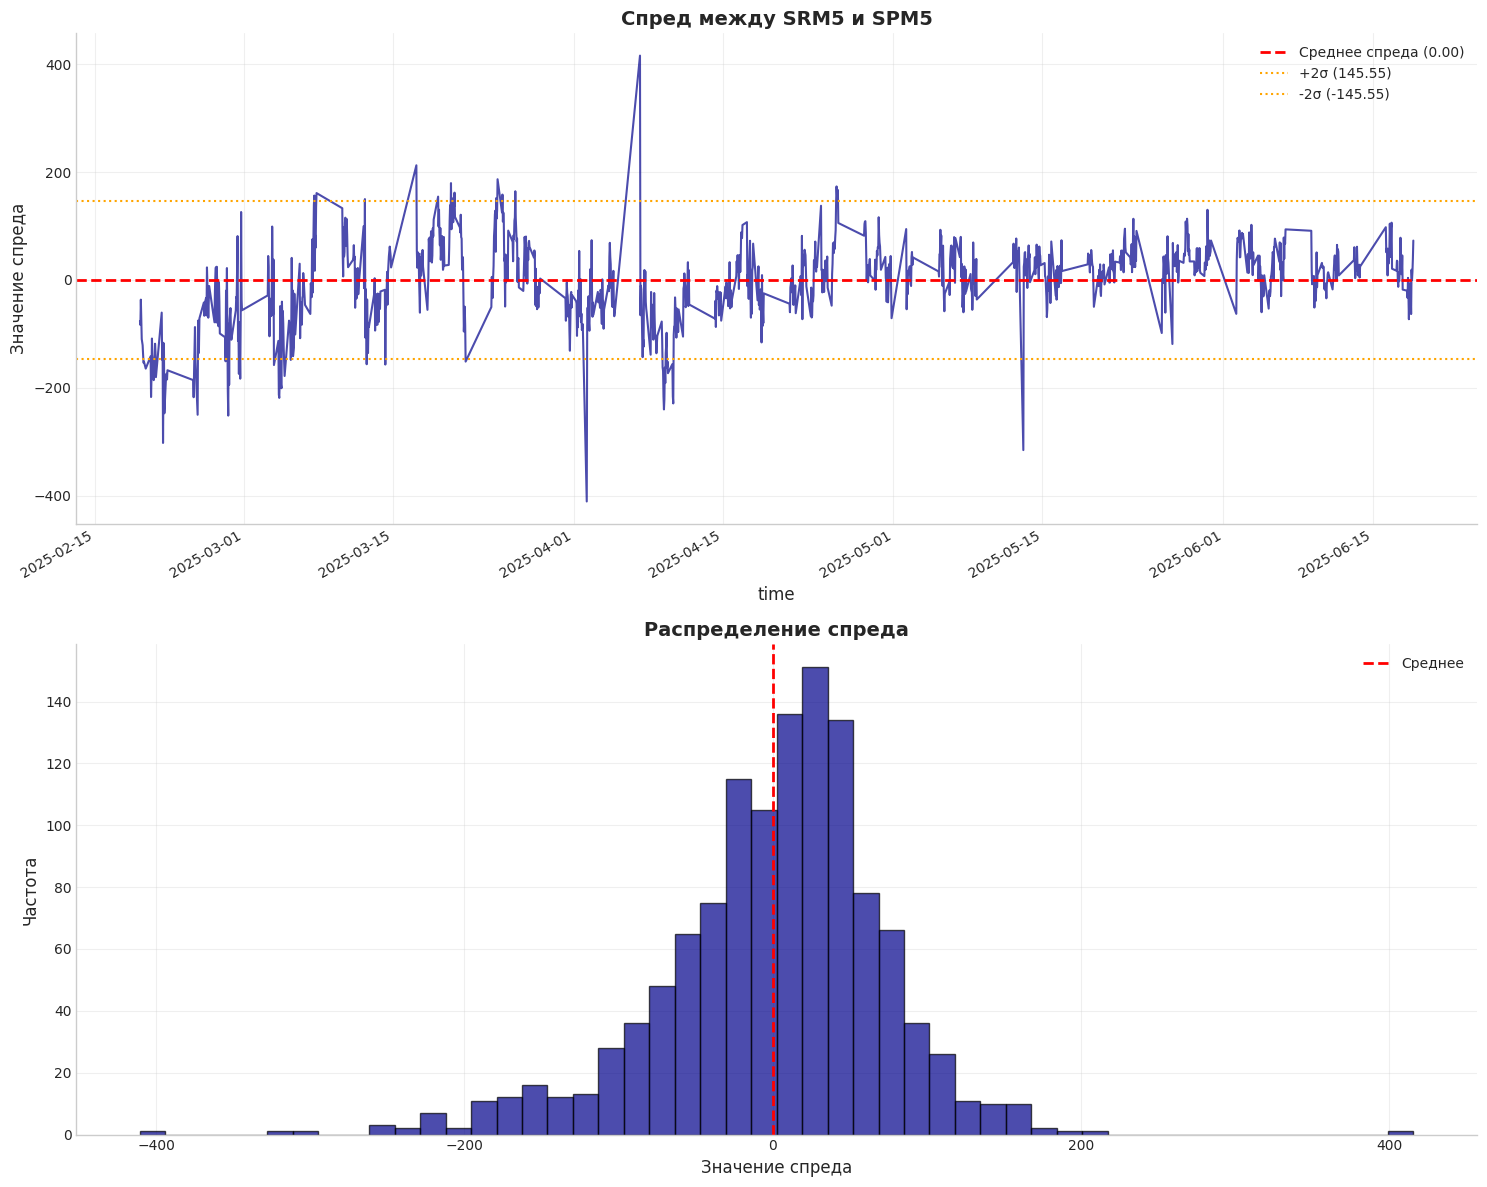

In [50]:
# Спред c учётом константы alpha (сдвига), получаемой из регрессии
spread = series1 - coint_result['beta'] * series2 - coint_result['alpha']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

spread.plot(ax=ax1, color='darkblue', alpha=0.7)
ax1.axhline(spread.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Среднее спреда ({spread.mean():.2f})')
ax1.axhline(spread.mean() + 2*spread.std(), color='orange', linestyle=':', 
            label=f'+2σ ({spread.mean() + 2*spread.std():.2f})')
ax1.axhline(spread.mean() - 2*spread.std(), color='orange', linestyle=':', 
            label=f'-2σ ({spread.mean() - 2*spread.std():.2f})')
ax1.set_title('Спред между SRM5 и SPM5', fontsize=14, fontweight='bold')
ax1.set_ylabel('Значение спреда', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Гистограмма распределения спреда
spread.hist(bins=50, ax=ax2, alpha=0.7, color='darkblue', edgecolor='black')
ax2.axvline(spread.mean(), color='red', linestyle='--', linewidth=2, label='Среднее')
ax2.set_title('Распределение спреда', fontsize=14, fontweight='bold')
ax2.set_xlabel('Значение спреда', fontsize=12)
ax2.set_ylabel('Частота', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [51]:
p_value, is_stationary = analyzer.check_stationarity(spread)
print(f"\n Проверка стационарности спреда (тест Дики-Фуллера):")
print("=" * 50)
print(f"P-value: {p_value:.6f}")
print(f"Спред стационарен: {'Да' if is_stationary else 'Нет'}")

print(f"\nСтатистика спреда:")
print(f"Среднее: {spread.mean():.4f}")
print(f"Стандартное отклонение: {spread.std():.4f}")
print(f"Минимум: {spread.min():.4f}")
print(f"Максимум: {spread.max():.4f}")


 Проверка стационарности спреда (тест Дики-Фуллера):
P-value: 0.000000
Спред стационарен: Да

Статистика спреда:
Среднее: 0.0000
Стандартное отклонение: 72.7737
Минимум: -410.4648
Максимум: 415.6481


## 3. Бэктестинг стратегии парного трейдинга

Стратегия парного трейдинга основана на предположении о возврате спреда к среднему значению. Торговые сигналы генерируются на основе Z-score спреда: позиция открывается при превышении порогового значения и закрывается при возврате к нейтральному уровню. В данном разделе проводится полный цикл бэктестинга с учетом транзакционных издержек.


In [52]:
LOOKBACK = 60           # Размер скользящего окна для расчета Z-score
ENTRY_THRESHOLD = 2.0   # Порог входа в позицию (в стандартных отклонениях)
EXIT_THRESHOLD = 0.5    # Порог выхода из позиции (в стандартных отклонениях)
MIN_ESTIMATION_WINDOW = 512  # Минимальное окно для оценки коинтеграции (часов)

print("Параметры стратегии парного трейдинга:")
print("-" * 45)
print(f"Размер скользящего окна: {LOOKBACK} периодов")
print(f"Порог входа в позицию: ±{ENTRY_THRESHOLD} стандартных отклонений")
print(f"Порог выхода из позиции: ±{EXIT_THRESHOLD} стандартных отклонений")
print(f"Минимальное окно оценки: {MIN_ESTIMATION_WINDOW} часов")

# Инициализация модуля бэктестинга
backtester = Backtester(
    series_1=series1,
    series_2=series2,
    lookback=LOOKBACK, 
    entry_threshold=ENTRY_THRESHOLD,
    exit_threshold=EXIT_THRESHOLD,
    min_estimation_window=MIN_ESTIMATION_WINDOW
)

results = backtester.run_full_backtest(analyzer)
print("Бэктестинг завершен успешно.")


2025-06-21 21:46:19,852 - INFO - Запуск бэктеста на 1216 точках


Параметры стратегии парного трейдинга:
---------------------------------------------
Размер скользящего окна: 60 периодов
Порог входа в позицию: ±2.0 стандартных отклонений
Порог выхода из позиции: ±0.5 стандартных отклонений
Минимальное окно оценки: 512 часов


2025-06-21 21:46:20,115 - INFO - Количество часов: 1215


Бэктестинг завершен успешно.


### 3.1 Анализ торговых сигналов

Z-score представляет собой нормализованное отклонение спреда от его скользящего среднего. Торговые сигналы генерируются при пересечении Z-score пороговых значений. На графике отображены моменты входа в длинные и короткие позиции, а также точки выхода из позиций.

**ВАЖНО**: используется walk-forward анализ, где:
- Коэффициенты коинтеграции пересчитываются динамически каждые 16 часов
- Z-score рассчитывается только на основе прошлых данных (без заглядывания в будущее)

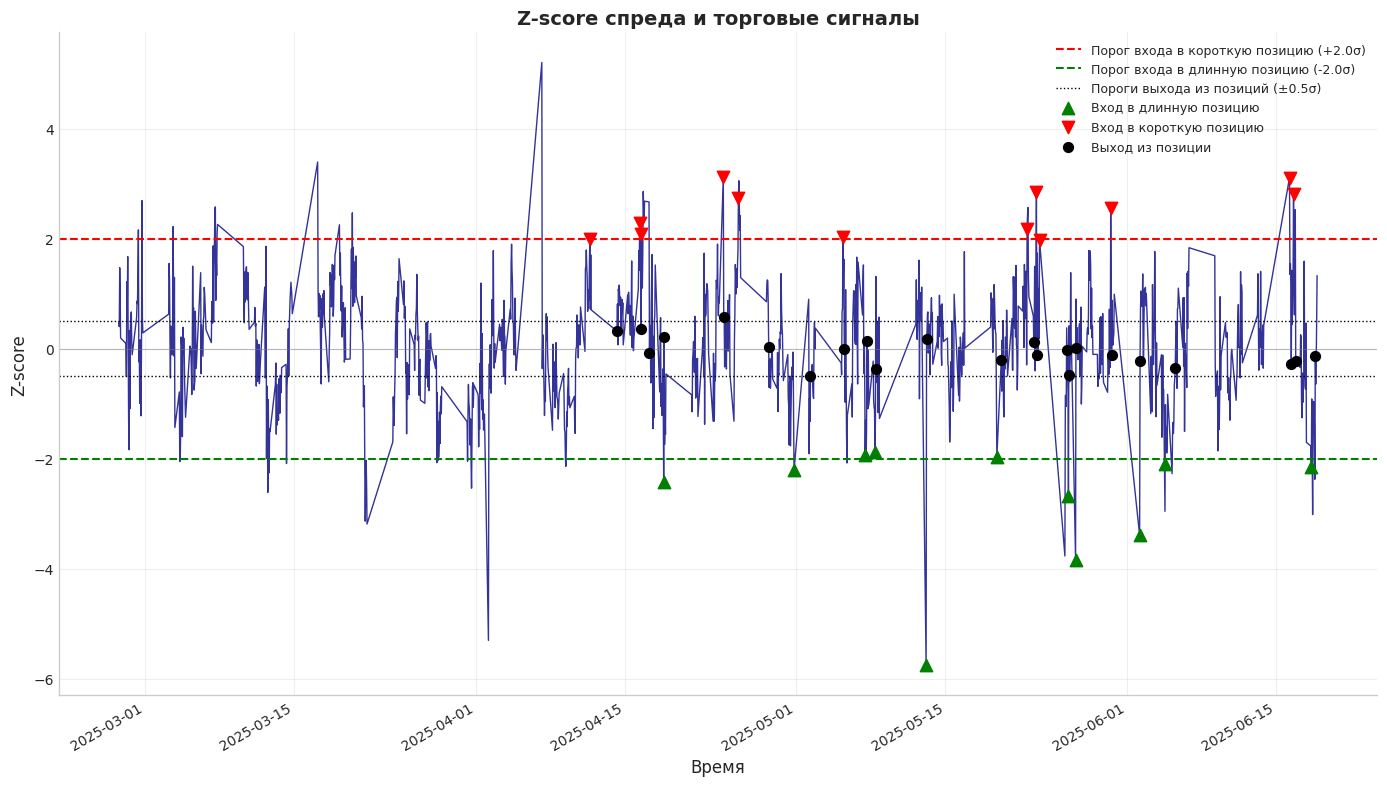

In [53]:
z_score = analyzer.calculate_zscore(
    series1, 
    series2, 
    coint_result['beta'], 
    backtester.lookback, 
    coint_result['alpha']
)

fig, ax = plt.subplots(figsize=(14, 8))

z_score.plot(ax=ax, color='navy', alpha=0.8, linewidth=1)

ax.axhline(backtester.entry_threshold, color='red', linestyle='--', linewidth=1.5, 
            label=f'Порог входа в короткую позицию (+{backtester.entry_threshold}σ)')
ax.axhline(-backtester.entry_threshold, color='green', linestyle='--', linewidth=1.5, 
            label=f'Порог входа в длинную позицию (-{backtester.entry_threshold}σ)')
ax.axhline(backtester.exit_threshold, color='black', linestyle=':', linewidth=1, 
            label=f'Пороги выхода из позиций (±{backtester.exit_threshold}σ)')
ax.axhline(-backtester.exit_threshold, color='black', linestyle=':', linewidth=1)
ax.axhline(0, color='gray', linestyle='-', alpha=0.5, linewidth=0.8)

signals = backtester.signals
signals_series = pd.Series(signals, index=series1.index)

# Определение точек входа и выхода
long_entries = (signals_series == 1) & (signals_series.shift(1) != 1)
short_entries = (signals_series == -1) & (signals_series.shift(1) != -1)
exits = (signals_series == 0) & (signals_series.shift(1) != 0)

ax.scatter(z_score.index[long_entries], z_score[long_entries], 
            marker='^', s=80, color='green', label='Вход в длинную позицию', zorder=5)
ax.scatter(z_score.index[short_entries], z_score[short_entries], 
            marker='v', s=80, color='red', label='Вход в короткую позицию', zorder=5)
ax.scatter(z_score.index[exits], z_score[exits], 
            marker='o', s=50, color='black', label='Выход из позиции', zorder=5)

ax.set_title('Z-score спреда и торговые сигналы', fontweight='bold')
ax.set_ylabel('Z-score')
ax.set_xlabel('Время')
ax.legend(fontsize=9, loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



In [54]:
total_signals = len(signals_series[signals_series != 0])
long_signals = len(signals_series[signals_series == 1])
short_signals = len(signals_series[signals_series == -1])

print("Статистика торговых сигналов:")
print("-" * 35)
print(f"Общее количество сигналов: {total_signals}")
print(f"Длинные позиции: {long_signals} ({long_signals/total_signals*100:.1f}%)")
print(f"Короткие позиции: {short_signals} ({short_signals/total_signals*100:.1f}%)")

Статистика торговых сигналов:
-----------------------------------
Общее количество сигналов: 99
Длинные позиции: 44 (44.4%)
Короткие позиции: 55 (55.6%)


### Визуализация кривой доходности

Построим кривую накопленной доходности стратегии для оценки её эффективности во времени.


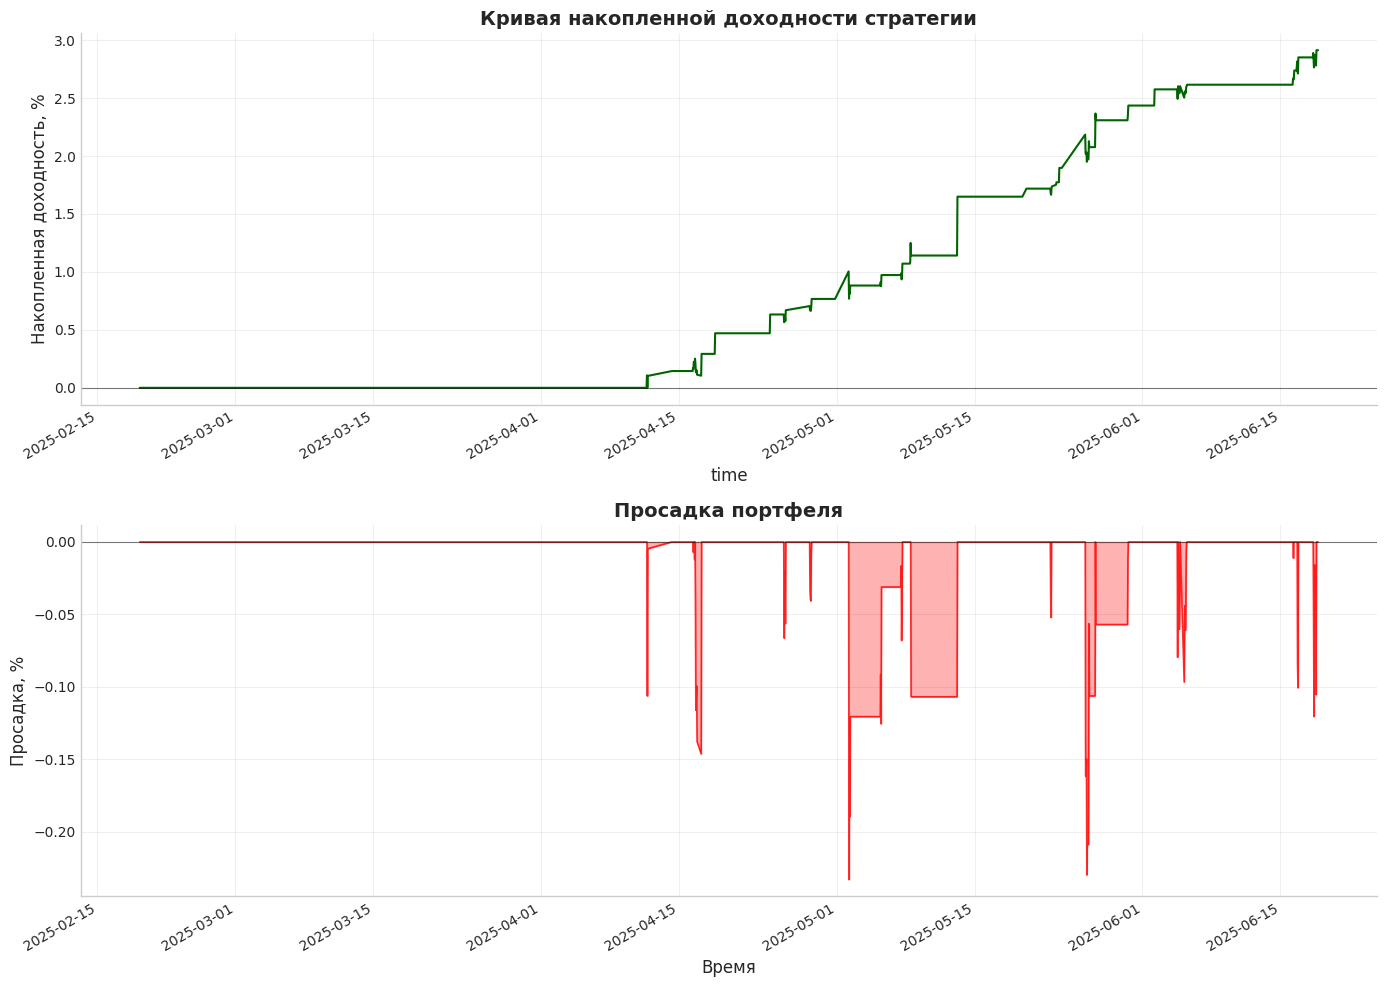

In [55]:
returns = results['returns']
equity_curve = pd.Series(np.cumprod(1 + returns), index=series1.index[1:])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

cumulative_returns = (equity_curve - 1) * 100
cumulative_returns.plot(ax=ax1, color='darkgreen', linewidth=1.5)
ax1.axhline(0, color='black', linestyle='-', alpha=0.5, linewidth=0.8)
ax1.set_title('Кривая накопленной доходности стратегии', fontweight='bold')
ax1.set_ylabel('Накопленная доходность, %')
ax1.grid(True, alpha=0.3)

peak = np.maximum.accumulate(equity_curve)
drawdown = (equity_curve / peak - 1) * 100

drawdown.plot(ax=ax2, color='red', alpha=0.8, linewidth=1.2)
ax2.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3)
ax2.axhline(0, color='black', linestyle='-', alpha=0.5, linewidth=0.8)
ax2.set_title('Просадка портфеля', fontweight='bold')
ax2.set_xlabel('Время')
ax2.set_ylabel('Просадка, %')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [56]:
total_return_pct = (equity_curve.iloc[-1] - 1) * 100
max_return_pct = cumulative_returns.max()
max_drawdown_pct = drawdown.min()

print("Ключевые показатели эффективности:")
print("-" * 40)
print(f"Итоговая доходность: {total_return_pct:.2f}%")
print(f"Максимальная доходность: {max_return_pct:.2f}%")
print(f"Максимальная просадка: {max_drawdown_pct:.2f}%")

Ключевые показатели эффективности:
----------------------------------------
Итоговая доходность: 2.91%
Максимальная доходность: 2.91%
Максимальная просадка: -0.23%


## 4. Результаты бэктестинга и оценка рисков

В данном разделе представлены комплексные метрики эффективности стратегии, включающие показатели доходности, риска и риск-скорректированной эффективности. Дополнительно проводится анализ рисков методом Монте-Карло для оценки потенциальных потерь.


In [57]:
performance = results['performance']
risk_analysis = results['risk_analysis']

print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ БЭКТЕСТИНГА")
print("=" * 40)

print("\nПОКАЗАТЕЛИ ДОХОДНОСТИ:")
print("-" * 40)
total_return_pct = performance['total_return'] * 100
annual_return_pct = performance['annual_return'] * 100
print(f"Общая доходность: {total_return_pct:+.2f}%")
print(f"Годовая доходность: {annual_return_pct:+.2f}%")

print("\nПОКАЗАТЕЛИ РИСКА:")
print("-" * 40)
volatility_pct = performance['volatility'] * 100
max_drawdown_pct = performance['max_drawdown'] * 100
print(f"Годовая волатильность: {volatility_pct:.2f}%")
print(f"Максимальная просадка: {max_drawdown_pct:.2f}%")

print("\nРИСК-СКОРРЕКТИРОВАННЫЕ ПОКАЗАТЕЛИ:")
print("-" * 40)
print(f"Коэффициент Шарпа: {performance['sharpe_ratio']:.3f}")

print("\nВРЕМЕННЫЕ ХАРАКТЕРИСТИКИ:")
print("-" * 40)
time_info = performance['time_info']
print(f"Общее количество часов: {time_info['total_hours']:,.0f}")
print(f"Количество торговых дней: {time_info['trading_days']:.1f}")

print("\nАНАЛИЗ РИСКОВ (МОНТЕ-КАРЛО):")
print("-" * 40)
print(f"Value at Risk (95%): {risk_analysis['var_95']*100:.2f}%")
print(f"Conditional VaR (95%): {risk_analysis['cvar_95']*100:.2f}%")

from IPython.display import HTML

metrics_html = f"""
<div style="background-color: #f8f9fa; padding: 20px; border-radius: 8px; margin: 20px 0; border: 1px solid #dee2e6;">
    <h3 style="color: #2c3e50; text-align: center; margin-bottom: 20px; font-family: 'Segoe UI', sans-serif;">Сводка результатов бэктестинга</h3>
    <table style="width: 100%; border-collapse: collapse; font-family: 'Segoe UI', sans-serif; font-size: 14px;">
        <tr style="background-color: #495057; color: white;">
            <th style="padding: 12px; text-align: left; border: 1px solid #dee2e6;">Показатель</th>
            <th style="padding: 12px; text-align: right; border: 1px solid #dee2e6;">Значение</th>
        </tr>
        <tr style="background-color: #f8f9fa;">
            <td style="padding: 10px; border: 1px solid #dee2e6; color: #495057;">Общая доходность</td>
            <td style="padding: 10px; text-align: right; border: 1px solid #dee2e6; font-weight: bold; color: {'#28a745' if total_return_pct > 0 else '#dc3545'};">{total_return_pct:+.2f}%</td>
        </tr>
        <tr>
            <td style="padding: 10px; border: 1px solid #dee2e6; color: #495057;">Годовая доходность</td>
            <td style="padding: 10px; text-align: right; border: 1px solid #dee2e6; font-weight: bold; color: {'#28a745' if annual_return_pct > 0 else '#dc3545'};">{annual_return_pct:+.2f}%</td>
        </tr>
        <tr style="background-color: #f8f9fa;">
            <td style="padding: 10px; border: 1px solid #dee2e6; color: #495057;">Годовая волатильность</td>
            <td style="padding: 10px; text-align: right; border: 1px solid #dee2e6; font-weight: bold; color: {'#28a745' if volatility_pct > 0 else '#dc3545'};">{volatility_pct:.2f}%</td>
        </tr>
        <tr>
            <td style="padding: 10px; border: 1px solid #dee2e6; color: #495057;">Коэффициент Шарпа</td>
            <td style="padding: 10px; text-align: right; border: 1px solid #dee2e6; font-weight: bold; color: {'#28a745' if performance['sharpe_ratio'] > 1 else '#ffc107' if performance['sharpe_ratio'] > 0.5 else '#dc3545'};">{performance['sharpe_ratio']:.3f}</td>
        </tr>
        <tr style="background-color: #f8f9fa;">
            <td style="padding: 10px; border: 1px solid #dee2e6; color: #495057;">Максимальная просадка</td>
            <td style="padding: 10px; text-align: right; border: 1px solid #dee2e6; color: #dc3545; font-weight: bold;">{max_drawdown_pct:.2f}%</td>
        </tr>
    </table>
</div>
"""

display(HTML(metrics_html))


ИТОГОВЫЕ РЕЗУЛЬТАТЫ БЭКТЕСТИНГА

ПОКАЗАТЕЛИ ДОХОДНОСТИ:
----------------------------------------
Общая доходность: +2.91%
Годовая доходность: +10.00%

ПОКАЗАТЕЛИ РИСКА:
----------------------------------------
Годовая волатильность: 1.81%
Максимальная просадка: -0.23%

РИСК-СКОРРЕКТИРОВАННЫЕ ПОКАЗАТЕЛИ:
----------------------------------------
Коэффициент Шарпа: 5.528

ВРЕМЕННЫЕ ХАРАКТЕРИСТИКИ:
----------------------------------------
Общее количество часов: 1,215
Количество торговых дней: 75.9

АНАЛИЗ РИСКОВ (МОНТЕ-КАРЛО):
----------------------------------------
Value at Risk (95%): 1.20%
Conditional VaR (95%): 0.73%


Показатель,Значение
Общая доходность,+2.91%
Годовая доходность,+10.00%
Годовая волатильность,1.81%
Коэффициент Шарпа,5.528
Максимальная просадка,-0.23%


## 5. Заключение

Данное исследование представляет комплексный анализ эффективности стратегии парного трейдинга, примененной к обыкновенным и привилегированным акциям ПАО Сбербанк. **Особое внимание уделено устранению Look-Ahead Bias** через реализацию walk-forward анализа.

### Выполненный анализ:

1. **Предварительный анализ данных** - загрузка и визуализация временных рядов цен закрытия
2. **Тест коинтеграции** - применение двухэтапного теста Энгла-Грейнджера для проверки долгосрочной равновесной связи
3. **Анализ стационарности спреда** - проверка стационарности коинтегрирующего остатка
4. **Разработка торговой стратегии** - генерация сигналов на основе Z-score с заданными порогами
5. **Бэктестинг** - тестирование стратегии на исторических данных с учетом транзакционных издержек
6. **Оценка рисков** - анализ просадки и применение метода Монте-Карло


### Направления для дальнейших исследований:

1. **Оптимизация параметров** - подбор оптимальных значений размера окна и пороговых уровней
2. **Расширение временного горизонта** - тестирование на более длительных периодах
3. **Альтернативные пары инструментов** - применение методологии к другим коинтегрированным активам
4. **Усовершенствование модели** - включение дополнительных факторов и фильтров сигналов
5. **Анализ режимов рынка** - исследование эффективности стратегии в различных рыночных условиях

